In [1]:
import os
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline
from math import log, exp, pi

# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.
# THIS COMMENT IS 72 CHARACTERS WITHOUT COUNTING THE NEWLINE AT THE END.

# use named tuples to improve readability

from collections import namedtuple

Point = namedtuple('Point', 'x y')
Extent = namedtuple('Extent', 'width height')
Rectangle = namedtuple('Rectangle', 'center extent')


## Code for Least Squares Fit

In [2]:
def sigma_squared_for_fwhm(fwhm):
    return fwhm**2 / (8 * log(2))

def make_gaussian(fwhm):
    sigma_squared = sigma_squared_for_fwhm(fwhm)
    normalization = 1 / (2 * pi * sigma_squared)
    def gaussian(x, y):
        return normalization * exp(-(x**2 + y**2) / (2 * sigma_squared))
    return gaussian

# The following mess of integers defines the parameter positions in the parameter vector
PINDEX_TARGET_BACKGROUND = 0  # NB: THE TARGET BACKGROUND IS IN ADDITION TO THE GENERAL_BACKGROUND
PINDEX_FWHM = 1
POFFSET_BASE = 2  # the number of indices above -- will grow if we further model target background
POFFSET_MULTIPLE = 3  # the number of indices below -- not expected to change
POFFSETINDEX_FLUX = 0
POFFSETINDEX_CENTER_RELATIVE_X = 1  # NB: THIS IS RELATIVE TO THE CENTER OF THE EXTENT
POFFSETINDEX_CENTER_RELATIVE_Y = 2  # NB: THIS IS RELATIVE TO THE CENTER OF THE EXTENT

def roi_model_for_parameters(extent, k, centers, parameters):
    print('parameters are')
    print(parameters)
    fwhm = parameters[PINDEX_FWHM]
    target_background = parameters[PINDEX_TARGET_BACKGROUND]
    base_index_k = POFFSET_BASE + k * POFFSET_MULTIPLE
    flux = parameters[base_index_k + POFFSETINDEX_FLUX]
    center_relative_x = parameters[base_index_k + POFFSETINDEX_CENTER_RELATIVE_X]
    center_relative_y = parameters[base_index_k + POFFSETINDEX_CENTER_RELATIVE_Y]
    model_roi_data = np.full((extent.height, extent.width), target_background) # height before width
    gaussian = make_gaussian(fwhm)
    for j in range(extent.height):
        for i in range(extent.width):
            model_roi_data[j, i] += flux * gaussian(
                i - extent.width // 2 - center_relative_x,
                j - extent.height // 2 - center_relative_y
            )
    print('model data is')
    print(model_roi_data)
    return model_roi_data

def view_extent_of_data(image_data, center, extent):
    left = center.x - extent.width // 2
    right = left + extent.width
    top = center.y - extent.height // 2
    bottom = top + extent.height
    view = image_data[top:bottom, left:right]
    return view

def make_image_data(width, height, centers, extent, parameters):
    target_background = parameters[PINDEX_TARGET_BACKGROUND]
    image_data = np.full((height, width), target_background) # height before width in the array shape
    for k in range(len(centers)):
        print('calling roi_model_for_parameters from make_image_data')
        model_roi_data = roi_model_for_parameters(extent, k, centers, parameters)
        view = view_extent_of_data(image_data, centers[k], extent)
        for j in range(extent.height):
            for i in range(extent.width):
                view[j, i] = model_roi_data[j, i]
    return image_data

def roi_residuals(image_data, k, centers, extent, parameters):
    roi_view = view_extent_of_data(image_data, centers[k], extent)
    print('calling roi_model_for_parameters from roi_residuals')
    roi_model = roi_model_for_parameters(extent, k, centers, parameters)
    return roi_view - roi_model

def make_residuals_function(image_data, centers, extent):
    def residuals_function(parameters):
        all_roi_residuals = [
            roi_residuals(image_data, k, centers, extent, parameters)
            for k, center in enumerate(centers)
        ]
        raveled = np.concatenate(all_roi_residuals).ravel()
        print('residuals vector')
        print(raveled)
        return raveled
    
    return residuals_function


## Testing

We test the least squares fitting code above with generated data.

### Generate the Data

In [3]:
# The following are in all caps and prefixed TEST to avoid collisions with the real data.

TEST_DATA_WIDTH = 4
TEST_DATA_HEIGHT = 3

TEST_EXTENT_HALF_WIDTH = 1
TEST_EXTENT_HALF_HEIGHT = TEST_EXTENT_HALF_WIDTH
TEST_EXTENT_WIDTH = 2 * TEST_EXTENT_HALF_WIDTH + 1
TEST_EXTENT_HEIGHT = TEST_EXTENT_WIDTH
TEST_EXTENT = Extent(TEST_EXTENT_WIDTH, TEST_EXTENT_HEIGHT)

TEST_CENTERS = [
    Point(1, 1), # test target
]

TEST_CENTER_OFFSETS = [
    Point(-0.3, -0.2), # test target
]

TEST_TARGET_BACKGROUND = 10.0

TEST_FWHM = 2.0

TEST_FLUXES = [
    50.0,
]

TEST_PARAMETERS = [
    TEST_TARGET_BACKGROUND,
    TEST_FWHM
]

for k in range(len(TEST_CENTERS)):
    TEST_PARAMETERS.append(TEST_FLUXES[k])
    TEST_PARAMETERS.append(TEST_CENTER_OFFSETS[k].x)
    TEST_PARAMETERS.append(TEST_CENTER_OFFSETS[k].y)


TEST_IMAGE_DATA = make_image_data(
    TEST_DATA_WIDTH, TEST_DATA_HEIGHT,
    TEST_CENTERS,
    TEST_EXTENT,
    TEST_PARAMETERS
)


calling roi_model_for_parameters from make_image_data
parameters are
[10.0, 2.0, 50.0, -0.3, -0.2]
model data is
[[15.04059376 16.65110334 12.19404587]
 [17.64011147 20.08118752 13.32555167]
 [12.89506088 13.82005573 11.26014844]]


### Display the Test Image

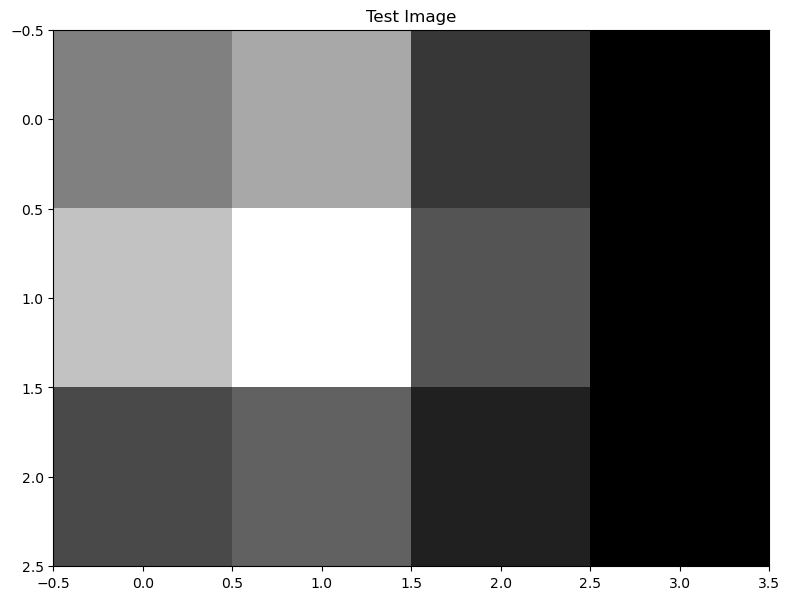

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(TEST_IMAGE_DATA, cmap='gray')
axes.set_title("Test Image")

plt.tight_layout()
plt.show()


### Fit the Test Image

In [5]:
# The following are in all caps and prefixed TEST to avoid collisions with the real fit.

TEST_INITIAL_GUESS_FOR_TARGET_BACKGROUND = 5.0
TEST_INITIAL_GUESS_FOR_FWHM = 3.0

TEST_INITIAL_PARAMETER_VECTOR = [
    TEST_INITIAL_GUESS_FOR_TARGET_BACKGROUND,
    TEST_INITIAL_GUESS_FOR_FWHM
]

for _ in range(len(TEST_CENTERS)):
    TEST_INITIAL_PARAMETER_VECTOR.append(10.0)  # Initial guess for flux
    TEST_INITIAL_PARAMETER_VECTOR.append(0.0)   # Initial guess for center_relative_x
    TEST_INITIAL_PARAMETER_VECTOR.append(0.0)   # Initial guess for center_relative_y
    
TEST_RESIDUALS_FUNCTION = make_residuals_function(TEST_IMAGE_DATA, TEST_CENTERS, TEST_EXTENT)


In [7]:
TEST_BOUNDS = [
    [
        0.0,
        1.0,
        0.0,
        -TEST_EXTENT_HALF_WIDTH,
        -TEST_EXTENT_HALF_HEIGHT
    ],[
        np.inf,
        15.0,
        np.inf,
        TEST_EXTENT_HALF_WIDTH,
        TEST_EXTENT_HALF_HEIGHT
    ]
]


TEST_RESULT = least_squares(TEST_RESIDUALS_FUNCTION, np.array(TEST_INITIAL_PARAMETER_VECTOR), bounds=TEST_BOUNDS)


calling roi_model_for_parameters from roi_residuals
parameters are
[ 5.  3. 10.  0.  0.]
model data is
[[5.52955473 5.72061278 5.52955473]
 [5.72061278 5.98060267 5.72061278]
 [5.52955473 5.72061278 5.52955473]]
residuals vector
[ 9.51103903 10.93049056  6.66449114 11.91949869 14.10058486  7.60493889
  7.36550615  8.09944295  5.73059371]
calling roi_model_for_parameters from roi_residuals
parameters are
[ 5.00000007  3.         10.          0.          0.        ]
model data is
[[5.5295548  5.72061286 5.5295548 ]
 [5.72061286 5.98060274 5.72061286]
 [5.5295548  5.72061286 5.5295548 ]]
residuals vector
[ 9.51103896 10.93049049  6.66449106 11.91949861 14.10058478  7.60493882
  7.36550608  8.09944288  5.73059364]
calling roi_model_for_parameters from roi_residuals
parameters are
[ 5.          3.00000004 10.          0.          0.        ]
model data is
[[5.52955472 5.72061277 5.52955472]
 [5.72061277 5.98060264 5.72061277]
 [5.52955472 5.72061277 5.52955472]]
residuals vector
[ 9.5110390

In [8]:
TEST_RESULT.x

array([10.        ,  2.        , 49.99999999, -0.3       , -0.2       ])